# Salary Predictions Based on Job Descriptions

In [1]:
#import your libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

#your info here
__author__ = "Albert Ntiri"
__email__ = "albert.ntiri@gmail.com"

In [2]:
train_features = pd.read_csv('data/train_features.csv')
train_salaries = pd.read_csv('data/train_salaries.csv')
test_features = pd.read_csv('data/test_features.csv')

training_combined = pd.merge(train_features, train_salaries, how='inner', on='jobId')

## Define Classes

In [3]:
class process_data():
    def __init__(self, data):
        self.data = data
    
    # Drop rows for 0-salary jobs
    def clean_data(self):
        self.data.drop(index = self.data[self.data.salary == 0].index, axis = 0, inplace = True)
    
    # Convert categorical variables to numeric based on hierarchy
    def label_encode(self, col, new_col, map_dict):
        self.data[new_col] = self.data[col].map(map_dict)
    
    # Convert non-hierarchical categorical variables to dummy variables
    def one_hot_encode(self, col, drop_first=False):
        self.data = pd.get_dummies(self.data, columns=[col], drop_first=drop_first)
        
    # drop single or list of columns
    def drop_columns(self, col):
        self.data.drop(col, axis=1, inplace=True)
    
    # Use function to convert old values in column to new values in new column
    def transform(self, col, new_col, function):
        self.data[new_col] = self.data[col].apply(function)
    
    # Create indicator value
    def convert_to_bool(self, string):
        if string == 'NONE':
            return 0
        else:
            return 1
    
    # Scale numeric variables to 0-1 range
    def normalize(self, col, new_col):
        self.data[new_col] = preprocessing.Normalizer(norm='max').transform([self.data[col]])[0]

In [4]:
class model():
    def __init__(self, model_type, data, features, target):
        self.model_type = model_type
        self.data = data
        self.features = features
        self.target = target
    
    def build_model(self, model_name, compare_df, test_size=.2):
        features_train, features_test, target_train, target_test = train_test_split(self.data[self.features], self.data[self.target], test_size=test_size)

        model = self.model_type.fit(features_train, target_train)
        training_r2 = model.score(features_train, target_train)
        self.model = model
        
        predicted_target = model.predict(features_test)
        test_r2 = r2_score(y_true=target_test, y_pred=predicted_target)
        mse = mean_squared_error(y_true=target_test, y_pred=predicted_target)

        compare_df.loc[model_name] = [training_r2, test_r2, mse]
        
        return model
    
    def cross_validate(self, cv, scoring='neg_mean_squared_error'):
        neg_mse = cross_val_score(self.model, self.data[self.features], self.data[self.target],  cv=cv, scoring=scoring)
        avg_mse = sum(neg_mse) / len(neg_mse) * -1.0
        print(avg_mse)
    
    def predict(self, data):
        predictions = self.model.predict(data)
        return predictions

In [5]:
class compare():
    def __init__(self, df):
        self.data = df
    
    def graph_results(self, col, name):
        metric_compare = self.data[col].sort_values()
        graph_title = col.replace('_',' ')
        file_name = 'charts/model_comparison_{}.jpg'.format(name)
        
        fig, ax = plt.subplots()
        ax.barh(metric_compare.index, metric_compare)
        ax.set_title(graph_title)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.savefig(file_name)

## Part 3 - DEVELOP

### ---- 7 Engineer features  ----

In [6]:
training_data = process_data(training_combined)

training_data.clean_data()

job_levels = {
    'JANITOR': 1,
    'JUNIOR': 2,
    'SENIOR': 3,
    'MANAGER': 4,
    'VICE_PRESIDENT': 5,
    'CFO': 6,
    'CTO': 6,
    'CEO': 7
}
training_data.label_encode('jobType', 'jobLevel', job_levels)

degree_levels = {
    'NONE': 0,
    'HIGH_SCHOOL': 1,
    'BACHELORS': 2,
    'MASTERS': 3,
    'DOCTORAL': 4
}
training_data.label_encode('degree', 'degreeLevel', degree_levels)

training_data.transform('major', 'majorInd', training_data.convert_to_bool)

training_data.one_hot_encode('major')

training_data.drop_columns('major_NONE')

training_data.one_hot_encode('industry', drop_first=True)

training_data.normalize('yearsExperience', 'yearsExperience_norm')

training_data.normalize('milesFromMetropolis', 'milesFromMetropolis_norm')

old_columns = ['jobId', 'companyId', 'jobType', 'degree', 'yearsExperience', 'milesFromMetropolis']
training_data.drop_columns(old_columns)

### ---- 8 Create models ----

In [7]:
# Initialize different models
lin_reg = linear_model.LinearRegression()
lasso_reg = linear_model.Lasso(alpha=.01)
ridge_reg = linear_model.Ridge(alpha=.01)
SGD_reg = linear_model.SGDRegressor(penalty='l1', alpha=.01, max_iter=1000)
GB_reg = GradientBoostingRegressor(n_estimators=500, max_depth=6)

In [8]:
# Set up different features combinations as variables

features1_joblevel = ['jobLevel']
features2_degree = ['degreeLevel']
features3_yearsexperience = ['yearsExperience_norm']
features4_milesfrommetropolis = ['milesFromMetropolis_norm']
features5_industries = ['industry_EDUCATION', 'industry_FINANCE', 'industry_HEALTH', 'industry_OIL', 'industry_SERVICE', 'industry_WEB']
features6_majors = ['major_BIOLOGY', 'major_BUSINESS', 'major_CHEMISTRY', 'major_COMPSCI', 'major_ENGINEERING', 'major_LITERATURE', 'major_MATH', 'major_PHYSICS']
features7_majorind = ['majorInd']
features8_nomajorind = features1_joblevel + features2_degree + features3_yearsexperience + features4_milesfrommetropolis + features5_industries + features6_majors
features9_all = features8_nomajorind + features7_majorind

### ---- 9 Test models ----

In [9]:
# Set up model comparison dataframe
feature_compare = pd.DataFrame(columns=['Training_R2', 'Test_R2', 'Mean_Squared_Error'])

# Build model for each previously-defined set of features
lreg1 = model(lin_reg, training_data.data, features1_joblevel, 'salary')
lreg1.build_model('lr_joblevel', compare_df=feature_compare)

lreg2 = model(lin_reg, training_data.data, features2_degree, 'salary')
lreg2.build_model('lr_degree', compare_df=feature_compare)

lreg3 = model(lin_reg, training_data.data, features3_yearsexperience, 'salary')
lreg3.build_model('lr_yearsexperience', compare_df=feature_compare)

lreg4 = model(lin_reg, training_data.data, features4_milesfrommetropolis, 'salary')
lreg4.build_model('lr_milesfrommetropolis', compare_df=feature_compare)

lreg5 = model(lin_reg, training_data.data, features5_industries, 'salary')
lreg5.build_model('lr_industries', compare_df=feature_compare)

lreg6 = model(lin_reg, training_data.data, features6_majors, 'salary')
lreg6.build_model('lr_majors', compare_df=feature_compare)

lreg7 = model(lin_reg, training_data.data, features7_majorind, 'salary')
lreg7.build_model('lr_majorind', compare_df=feature_compare)

lreg8 = model(lin_reg, training_data.data, features8_nomajorind, 'salary')
lreg8.build_model('lr_nomajorind', compare_df=feature_compare)

lreg9 = model(lin_reg, training_data.data, features9_all, 'salary')
lreg9.build_model('lr_all', compare_df=feature_compare)

feature_compare

# Using all features yields the best results

,Training_R2,Test_R2,Mean_Squared_Error
lr_joblevel,0.347184,0.348182,976.652324
lr_degree,0.147498,0.147455,1277.897479
lr_yearsexperience,0.140133,0.142643,1282.841528
lr_milesfrommetropolis,0.088558,0.088852,1362.703513
lr_industries,0.087728,0.089011,1368.730621
lr_majors,0.143375,0.143466,1279.020366
lr_majorind,0.138346,0.136418,1287.740127
lr_nomajorind,0.743326,0.742505,384.673416
lr_all,0.743306,0.742589,385.759924


In [10]:
# Set up model comparison dataframe
algorithm_compare = pd.DataFrame(columns=['Training_R2', 'Test_R2', 'Mean_Squared_Error'])

# Build model for each previously-set up algorithm
linear = model(lin_reg, training_data.data, features9_all, 'salary')
linear.build_model('Linear_Regression', compare_df=algorithm_compare)

lasso = model(lasso_reg, training_data.data, features9_all, 'salary')
lasso.build_model('Lasso_Regression', compare_df=algorithm_compare)

ridge = model(ridge_reg, training_data.data, features9_all, 'salary')
ridge.build_model('Ridge_Regression', compare_df=algorithm_compare)

sgd = model(SGD_reg, training_data.data, features9_all, 'salary')
sgd.build_model('Stochastic_Gradient_Descent', compare_df=algorithm_compare)

gb = model(GB_reg, training_data.data, features9_all, 'salary')
gb.build_model('Gradient_Boosting', compare_df=algorithm_compare)

algorithm_compare

# Gradient boosting yields the best results

,Training_R2,Test_R2,Mean_Squared_Error
Linear_Regression,0.743296,0.742621,384.332272
Lasso_Regression,0.743015,0.743694,384.456165
Ridge_Regression,0.743122,0.743324,384.661448
Stochastic_Gradient_Descent,0.742861,0.743279,385.185908
Gradient_Boosting,0.768261,0.762020,356.877769


In [11]:
# Perform cross-validation on gradient boosting model to see if it significantly changes the results
gb.cross_validate(5)

356.8659257691227


### ---- 10 Select best model  ----

Based on the comparisons, the model that will be used for production is gradient boosting with 500 iterations and a max depth of 6.  The R^2 is around .76 and the mean squared error is around 356.  Cross validation did not change the results much but significantly slowed down performance so I will leave it out.

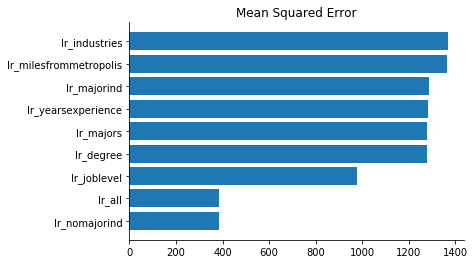

In [12]:
# Graph mean squared errors to compare results for different feature combinations

feature_comp = compare(feature_compare)
feature_comp.graph_results('Mean_Squared_Error', 'features')

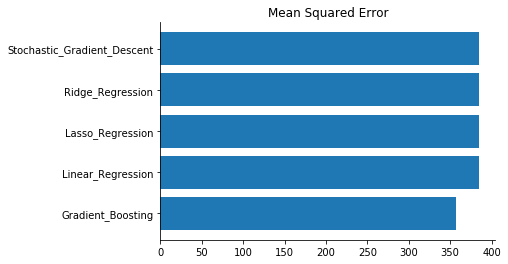

In [13]:
# Graph mean squared errors to compare results for different algorithms

algorithm_comp = compare(algorithm_compare)
algorithm_comp.graph_results('Mean_Squared_Error', 'algorithms')

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [14]:
# Process test data

test_data = process_data(test_features)

test_data.label_encode('jobType', 'jobLevel', job_levels)

test_data.label_encode('degree', 'degreeLevel', degree_levels)

test_data.transform('major', 'majorInd', training_data.convert_to_bool)

test_data.one_hot_encode('major')

test_data.drop_columns('major_NONE')

test_data.one_hot_encode('industry', drop_first=True)

test_data.normalize('yearsExperience', 'yearsExperience_norm')

test_data.normalize('milesFromMetropolis', 'milesFromMetropolis_norm')

test_data.drop_columns(old_columns)



gb_final = model(GB_reg, training_data.data, features9_all, 'salary')

gb_final.build_model('Production_Model', compare_df=algorithm_compare)

test_salaries = gb_final.predict(test_data.data)

### ---- 12 Deploy solution ----

In [15]:
# Save predictions to file

pd.DataFrame(test_salaries).to_csv('data/test_salaries.csv')